In [1]:
import matplotlib
%matplotlib inline 
%matplotlib nbagg
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from data_generator import get_batch, print_valid_characters
from tensorflow.python.framework.ops import reset_default_graph

import tf_utils

/Users/interactionlab/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Encoder-Decoder RNN based on LSTM / GRU

In the encoder-decoder structure one RNN (blue) encodes the input and a second RNN (red) calculates the target values. 
The first approach uses the last hidden state of the encoder to initialize the decoder. The second approach lets the decoder attend to different parts of the encoded input at different timesteps in the decoding process. 

<img src="files/enc-dec.png", width=400>

I use a RNN with gated recurrent units (GRU) as encoder. I also use the last hidden state of the encoder ($h^{enc}_T$) as input to the decoder which is also a GRU RNN. 

### The Data

The task is to translate from a meaning representation (MR) to a natural language utterance (NL). I generate NL utterance on a character level.

MR has the following form: 

        name: Eagle, eatType: restaurant, food: Chinese

NL reference for this MR may have the following form:

        Eagle is a Chinese restaurant.

For this demonstration, I generate three pairs of MR-NL only. I train and validate on the same three examples.

### Encoder Decoder model setup

Below is the TensorFlow model definition. I use an embedding layer to go from MR to vector representation of the input.

MR here has a length of 6, which is equal to the total number of attributes in the dataset (3 in our case: *name*, *eatType* and *food*) times 2 (we need a slot representing a value of each attribute). 

The vector of output NL has a length equal to the maximal number of characters in NL references in our dataset (24 in our case). Each element of the output vector may be in the range of (0, 256), which corresponds to a ASCII value of an output character. 

In [2]:
# resetting the graph
reset_default_graph()

# Setting up hyperparameters and general configs
MAX_DIGITS = 24
MIN_DIGITS = 24
NUM_INPUTS = 6 
NUM_OUTPUTS = 256 

BATCH_SIZE = 3
# try various learning rates 1e-2 to 1e-5
LEARNING_RATE = 0.005
X_EMBEDDINGS = 4
t_EMBEDDINGS = 8
NUM_UNITS_ENC = 10
NUM_UNITS_DEC = 10


# Setting up placeholders, these are the tensors that we "feed" to our network
Xs = tf.placeholder(tf.int32, shape=[None, None], name='X_input')
ts_in = tf.placeholder(tf.int32, shape=[None, None], name='t_input_in')
ts_out = tf.placeholder(tf.int32, shape=[None, None], name='t_input_out')
X_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_len = tf.placeholder(tf.int32, shape=[None], name='t_len')
t_mask = tf.placeholder(tf.float32, shape=[None, None], name='t_mask')

In [3]:
# Building the model

# first we build the embeddings to make our MR into dense, trainable vectors
X_embeddings = tf.get_variable('X_embeddings', [NUM_INPUTS, X_EMBEDDINGS],
                               initializer=tf.random_normal_initializer(stddev=0.1))
t_embeddings = tf.get_variable('t_embeddings', [NUM_OUTPUTS, t_EMBEDDINGS],
                               initializer=tf.random_normal_initializer(stddev=0.1))

# setting up weights for computing the final output
W_out = tf.get_variable('W_out', [NUM_UNITS_DEC, NUM_OUTPUTS])
b_out = tf.get_variable('b_out', [NUM_OUTPUTS])

X_embedded = tf.gather(X_embeddings, Xs, name='embed_X')
t_embedded = tf.gather(t_embeddings, ts_in, name='embed_t')

In [4]:
# forward encoding
enc_cell = tf.nn.rnn_cell.GRUCell(NUM_UNITS_ENC)#python.ops.rnn_cell.GRUCell
_, enc_state = tf.nn.dynamic_rnn(cell=enc_cell, inputs=X_embedded,
                                 sequence_length=X_len, dtype=tf.float32)

In [5]:
# decoding
# I am using a wrapper for decoding here, this wrapper is hardcoded to only use GRU
dec_out, valid_dec_out = tf_utils.decoder(enc_state, t_embedded, t_len, 
                                         NUM_UNITS_DEC, t_embeddings,
                                          W_out, b_out)

In [6]:
# reshaping to have [batch_size*seqlen, num_units]
out_tensor = tf.reshape(dec_out, [-1, NUM_UNITS_DEC])
valid_out_tensor = tf.reshape(valid_dec_out, [-1, NUM_UNITS_DEC])
# computing output
out_tensor = tf.matmul(out_tensor, W_out) + b_out
valid_out_tensor = tf.matmul(valid_out_tensor, W_out) + b_out
# reshaping back to sequence
b_size = tf.shape(X_len)[0] # use a variable I know has batch_size in [0]
seq_len = tf.shape(t_embedded)[1] # variable I know has sequence length in [1]
num_out = tf.constant(NUM_OUTPUTS) # casting NUM_OUTPUTS to a tensor variable
out_shape = tf.concat(0, [tf.expand_dims(b_size, 0),
                          tf.expand_dims(seq_len, 0),
                          tf.expand_dims(num_out, 0)])
out_tensor = tf.reshape(out_tensor, out_shape)
valid_out_tensor = tf.reshape(valid_out_tensor, out_shape)
y = out_tensor
y_valid = valid_out_tensor

### Defining the cost function, gradient clipping and accuracy

Because the targets are categorical I use the cross entropy error.
As the data is sequential I use the sequence to sequence cross entropy.
I also use the Adam optimizer from TensorFlow.

In [7]:
def loss_and_acc(preds):
    loss = tf_utils.sequence_loss_tensor(preds, ts_out, t_mask, NUM_OUTPUTS)
    # for regularization:
    #reg_scale = 0.00001
    #regularize = tf.contrib.layers.l2_regularizer(reg_scale)
    #params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    #reg_term = sum([regularize(param) for param in params])
    #loss += reg_term
    # calculate accuracy:
    argmax = tf.to_int32(tf.argmax(preds, 2))
    correct = tf.to_float(tf.equal(argmax, ts_out)) * t_mask
    accuracy = tf.reduce_sum(correct) / tf.reduce_sum(t_mask)
    return loss, accuracy, argmax

loss, accuracy, predictions = loss_and_acc(y)
loss_valid, accuracy_valid, predictions_valid = loss_and_acc(y_valid)

# use lobal step to keep track of iterations
global_step = tf.Variable(0, name='global_step', trainable=False)
# other optimizers possible: momentum or adadelta
optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
# extract gradients for each variable
grads_and_vars = optimizer.compute_gradients(loss)
# clipping by norm:
#gradients, variables = zip(*grads_and_vars)  # unzip list of tuples
#clipped_gradients, global_norm = (
#    tf.clip_by_global_norm(gradients, self.clip_norm) )
#grads_and_vars = zip(clipped_gradients, variables)
# apply gradients and make trainable function
train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

In [8]:
# here comes the dummy data (three examples)

batch_size=3

inputs = np.asarray([[0,1,1,1,3,0],
                     [0,2,1,1,3,0],
                     [0,1,1,2,3,0]]).astype('int32')
inputs_seqlen = np.asarray([6, 6, 6]).astype('int32')
targets_in = np.asarray([[3, 89, 105, 112, 112, 101, 101, 32, 105, 115, 32, 97, 32, 114, 101, 115, 116, 97, 117, 114, 97, 110, 116, 46],
                         [3, 69, 97, 103, 108, 101, 32, 105, 115, 32, 97, 32, 114, 101, 115, 116, 97, 117, 114, 97, 110, 116, 46, 0],
                         [3, 89, 105, 112, 112, 101, 101, 32, 105, 115, 32, 97, 32, 112, 117, 98, 46, 0, 0, 0, 0, 0, 0, 0]]).astype('int32')
targets_out = np.asarray([[89, 105, 112, 112, 101, 101, 32, 105, 115, 32, 97, 32, 114, 101, 115, 116, 97, 117, 114, 97, 110, 116, 46, 3],
                          [69, 97, 103, 108, 101, 32, 105, 115, 32, 97, 32, 114, 101, 115, 116, 97, 117, 114, 97, 110, 116, 46, 3, 0],
                          [89, 105, 112, 112, 101, 101, 32, 105, 115, 32, 97, 32, 112, 117, 98, 46, 3, 0, 0, 0, 0, 0, 0, 0]]).astype('int32')
targets_seqlen = np.asarray([24,23,17]).astype('int32')
targets_mask = np.asarray([[1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.],
                          [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,0.],
                          [1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,0.,0.,0.,0.,0.,0.,0.]]).astype('float32')
text_inputs = ['name: Yippee, eatType: restaurant',
               'name: Eagle, eatType: restaurant',
               'name: Yippee, eatType: pub']
text_targets_in = ['\x03Yippee is a restaurant.',
                   '\x03Eagle is a restaurant.',
                   '\x03Yippee is a pub.']
text_targets_out = ['Yippee is a restaurant.\x03',
                    'Eagle is a restaurant.\x03',
                    'Yippee is a pub.\x03']

for i in range(batch_size):
    print "\nSAMPLE",i
    print "TEXT INPUTS:\t\t\t", text_inputs[i]
    print "TEXT TARGETS INPUT:\t\t", text_targets_in[i]


SAMPLE 0
TEXT INPUTS:			name: Yippee, eatType: restaurant
TEXT TARGETS INPUT:		Yippee is a restaurant.

SAMPLE 1
TEXT INPUTS:			name: Eagle, eatType: restaurant
TEXT TARGETS INPUT:		Eagle is a restaurant.

SAMPLE 2
TEXT INPUTS:			name: Yippee, eatType: pub
TEXT TARGETS INPUT:		Yippee is a pub.


In [9]:
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))

# test train part
sess.run(tf.initialize_all_variables())
feed_dict = {Xs: inputs, X_len: inputs_seqlen, ts_in: targets_in,
             ts_out: targets_out, t_len: targets_seqlen}
fetches = [y]
res = sess.run(fetches=fetches, feed_dict=feed_dict)

# test validation part
fetches = [y_valid]
res = sess.run(fetches=fetches, feed_dict=feed_dict)

In [10]:
inputs_val = np.asarray([[0,1,1,1,3,0],
                     [0,2,1,1,3,0],
                     [0,1,1,2,3,0]]).astype('int32')
inputs_seqlen_val = np.asarray([6, 6, 6]).astype('int32')
targets_in_val = np.asarray([[3, 89, 105, 112, 112, 101, 101, 32, 105, 115, 32, 97, 32, 114, 101, 115, 116, 97, 117, 114, 97, 110, 116, 46],
                         [3, 69, 97, 103, 108, 101, 32, 105, 115, 32, 97, 32, 114, 101, 115, 116, 97, 117, 114, 97, 110, 116, 46, 0],
                         [3, 89, 105, 112, 112, 101, 101, 32, 105, 115, 32, 97, 32, 112, 117, 98, 46, 0, 0, 0, 0, 0, 0, 0]]).astype('int32')
targets_out_val = np.asarray([[89, 105, 112, 112, 101, 101, 32, 105, 115, 32, 97, 32, 114, 101, 115, 116, 97, 117, 114, 97, 110, 116, 46, 3],
                          [69, 97, 103, 108, 101, 32, 105, 115, 32, 97, 32, 114, 101, 115, 116, 97, 117, 114, 97, 110, 116, 46, 3, 0],
                          [89, 105, 112, 112, 101, 101, 32, 105, 115, 32, 97, 32, 112, 117, 98, 46, 3, 0, 0, 0, 0, 0, 0, 0]]).astype('int32')
targets_seqlen_val = np.asarray([24,23,17]).astype('int32')
text_inputs_val = ['name: Yippee, eatType: restaurant',
               'name: Eagle, eatType: restaurant',
               'name: Yippee, eatType: pub']
text_targets_in_val = ['\x03Yippee is a restaurant.',
                   '\x03Eagle is a restaurant.',
                   '\x03Yippee is a pub.']
text_targets_out_val = ['Yippee is a restaurant.\x03',
                    'Eagle is a restaurant.\x03',
                    'Yippee is a pub.\x03']

In [11]:
#Generate some dummy validation data (just a copy of training)

X_val, X_len_val, t_in_val, t_out_val, t_len_val, t_mask_val,\
text_inputs_val, text_targets_in_val, text_targets_out_val = \
inputs_val, inputs_seqlen_val, targets_in_val, targets_out_val, targets_seqlen_val, targets_mask,\
text_inputs_val, text_targets_in_val, text_targets_out_val

# First Approach. 

## Training

validating


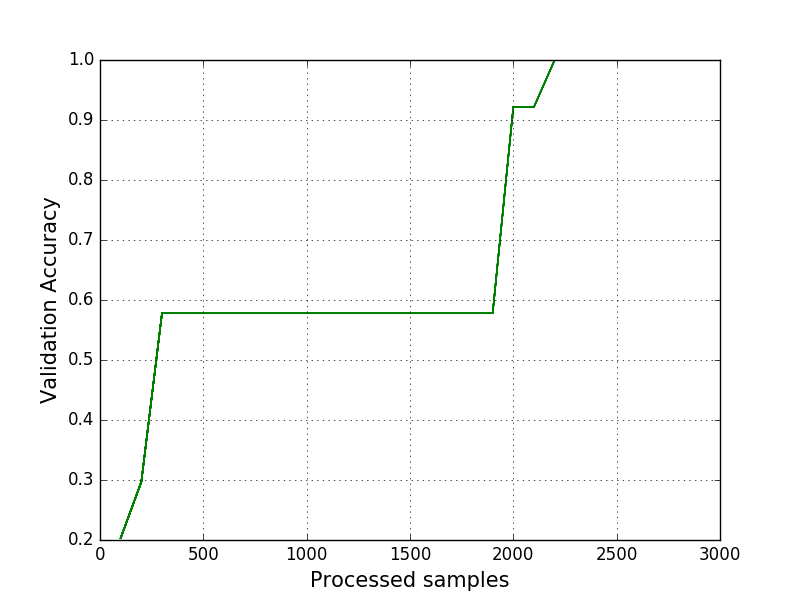

In [12]:
# setting up running parameters
val_interval = 100
samples_to_process = 3000 
samples_processed = 0
samples_val = []
costs, accs_val = [], []
plt.figure()
try:
    while samples_processed < samples_to_process:
        # load data
        X_tr, X_len_tr, t_in_tr, t_out_tr, t_len_tr, t_mask_tr,\
        text_inputs_tr, text_targets_in_tr, text_targets_out_tr = \
        inputs, inputs_seqlen, targets_in, targets_out, targets_seqlen, targets_mask,\
        text_inputs, text_targets_in, text_targets_out
        # make fetches
        fetches_tr = [train_op, loss, accuracy]
        # set up feed dict
        feed_dict_tr = {Xs: X_tr, X_len: X_len_tr, ts_in: t_in_tr,
             ts_out: t_out_tr, t_len: t_len_tr, t_mask: t_mask_tr}
        # run the model
        res = tuple(sess.run(fetches=fetches_tr, feed_dict=feed_dict_tr))
        _, batch_cost, batch_acc = res
        costs += [batch_cost]
        samples_processed += 1
        #if samples_processed % 1000 == 0: print batch_cost, batch_acc
        #validation data
        if samples_processed % val_interval == 0:
            print "validating"
            fetches_val = [accuracy_valid, y_valid]
            feed_dict_val = {Xs: X_val, X_len: X_len_val, ts_in: t_in_val,
                             ts_out: t_out_val, t_len: t_len_val, t_mask: t_mask_val}
            res = tuple(sess.run(fetches=fetches_val, feed_dict=feed_dict_val))
            acc_val, output_val = res
            samples_val += [samples_processed]
            accs_val += [acc_val]
            #print out the current results             
            #print t_out_val[0]
            #print np.argmax(output_val[0], axis=1)
            plt.plot(samples_val, accs_val, 'g-')
            plt.ylabel('Validation Accuracy', fontsize=15)
            plt.xlabel('Processed samples', fontsize=15)
            plt.title('', fontsize=20)
            plt.grid('on')
            plt.savefig("out.png")
            display.display(display.Image(filename="out.png"))
            display.clear_output(wait=True)
except KeyboardInterrupt:
    pass

In [13]:
print t_out_val

res = [[],[],[]]
for i in range(3):
    for each in t_out_val[i]:
        res[i].append(chr(each))
    print ''.join(res[i])

[[ 89 105 112 112 101 101  32 105 115  32  97  32 114 101 115 116  97 117
  114  97 110 116  46   3]
 [ 69  97 103 108 101  32 105 115  32  97  32 114 101 115 116  97 117 114
   97 110 116  46   3   0]
 [ 89 105 112 112 101 101  32 105 115  32  97  32 112 117  98  46   3   0
    0   0   0   0   0   0]]
Yippee is a restaurant.
Eagle is a restaurant. 
Yippee is a pub.       


In [14]:
for i in range(3):
    print np.argmax(output_val[i], axis=1)

res = [[],[],[]]
for i in range(3):
    for each in np.argmax(output_val[i], axis=1):
        res[i].append(chr(each))
    print ''.join(res[i])

[ 89 105 112 112 101 101  32 105 115  32  97  32 114 101 115 116  97 117
 114  97 110 116  46   3]
[ 69  97 103 108 101  32 105 115  32  97  32 114 101 115 116  97 117 114
  97 110 116  46   3   3]
[ 89 105 112 112 101 101  32 105 115  32  97  32 112 117  98  46   3   3
   3   3   3   3   3   3]
Yippee is a restaurant.
Eagle is a restaurant.
Yippee is a pub.


<IPython.core.display.Javascript object>


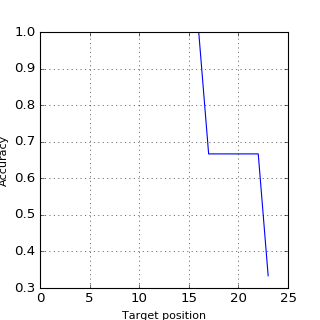

In [15]:
#plot of validation accuracy for each target position
plt.figure(figsize=(4,4))
plt.plot(np.mean(np.argmax(output_val,axis=2)==t_out_val,axis=0))
plt.ylabel('Accuracy', fontsize=10)
plt.xlabel('Target position', fontsize=10)
#plt.title('', fontsize=20)
plt.grid('on')
plt.show()

# Second Approach. Attention Decoder (LSTM)

The method of soft attention lets the Decoder model selective focus on which part of the encoder sequence it will use for each decoded output character.
This relieves the encoder from having to compress the input sequence into a fixed size vector representation passed on to the decoder. It also let us interrogate the decoder network about where it attends while producing the ouputs.

Next, I implement an LSTM-decoder with selective attention and show that it improves the performance of the example translation task.

The principle of attention models: 

1. Use the encoder to get the hidden represention $\{h^1_e, ...h^n_e\}$ for each position in the input sequence. 
2. for timestep $t$ in the decoder do for $m = 1...n$ : $a_m = f(h^m_e, h^d_t)$. Where f is a function returning a scalar value. 
3. You can then normalize the sequence of scalars $\{a_1, ... a_n\}$ to get probablities $\{p_1, ... p_n\}$.
4. Weight each $h^e_t$ by its probablity $p_t$ and sum to get $h_{in}$.
5. Use $h_{in}$ as an additional input to the decoder. $h_{in}$ is recalculated each time the decoder is updated.

In [16]:
# resetting the graph
reset_default_graph()

# Setting up hyperparameters and general configs
MAX_DIGITS = 24
MIN_DIGITS = 24
NUM_INPUTS = 6
NUM_OUTPUTS = 256 

BATCH_SIZE = 3
# try various learning rates 1e-2 to 1e-5
LEARNING_RATE = 0.005
X_EMBEDDINGS = 4
t_EMBEDDINGS = 8
NUM_UNITS_ENC = 10
NUM_UNITS_DEC = 10
NUM_UNITS_ATTN = 24


# Setting up placeholders, these are the tensors that will be fed to the network
Xs = tf.placeholder(tf.int32, shape=[None, None], name='X_input')
ts_in = tf.placeholder(tf.int32, shape=[None, None], name='t_input_in')
ts_out = tf.placeholder(tf.int32, shape=[None, None], name='t_input_out')
X_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_len = tf.placeholder(tf.int32, shape=[None], name='X_len')
t_mask = tf.placeholder(tf.float32, shape=[None, None], name='t_mask')

# Building the model

# first I build the embeddings to make the MR into dense, trainable vectors
X_embeddings = tf.get_variable('X_embeddings', [NUM_INPUTS, X_EMBEDDINGS],
                               initializer=tf.random_normal_initializer(stddev=0.1))
t_embeddings = tf.get_variable('t_embeddings', [NUM_OUTPUTS, t_EMBEDDINGS],
                               initializer=tf.random_normal_initializer(stddev=0.1))

# setting up weights for computing the final output
W_out = tf.get_variable('W_out', [NUM_UNITS_DEC, NUM_OUTPUTS])
b_out = tf.get_variable('b_out', [NUM_OUTPUTS])

X_embedded = tf.gather(X_embeddings, Xs, name='embed_X')
t_embedded = tf.gather(t_embeddings, ts_in, name='embed_t')

# forward encoding
enc_cell = tf.nn.rnn_cell.GRUCell(NUM_UNITS_ENC)#python.ops.rnn_cell.GRUCell
enc_out, enc_state = tf.nn.dynamic_rnn(cell=enc_cell, inputs=X_embedded,
                                 sequence_length=X_len, dtype=tf.float32)
# use below in case TF's does not work as intended
#enc_state, _ = tf_utils.encoder(X_embedded, X_len, 'encoder', NUM_UNITS_ENC)
#
#enc_state = tf.concat(1, [enc_state, enc_state])

# decoding
# I am using a wrapper for decoding here, this wrapper is hardcoded to only use GRU
dec_out, dec_out_valid, alpha_valid = \
    tf_utils.attention_decoder(enc_out, X_len, enc_state, t_embedded, t_len,
                               NUM_UNITS_DEC, NUM_UNITS_ATTN, t_embeddings,
                               W_out, b_out)

# reshaping to have [batch_size*seqlen, num_units]
out_tensor = tf.reshape(dec_out, [-1, NUM_UNITS_DEC])
out_tensor_valid = tf.reshape(dec_out_valid, [-1, NUM_UNITS_DEC])
# computing output
out_tensor = tf.matmul(out_tensor, W_out) + b_out
out_tensor_valid = tf.matmul(out_tensor_valid, W_out) + b_out
# reshaping back to sequence
b_size = tf.shape(X_len)[0] # use a variable that has batch_size in [0]
seq_len = tf.shape(t_embedded)[1] # variable that has sequence length in [1]
num_out = tf.constant(NUM_OUTPUTS) # casting NUM_OUTPUTS to a tensor variable
out_shape = tf.concat(0, [tf.expand_dims(b_size, 0),
                          tf.expand_dims(seq_len, 0),
                          tf.expand_dims(num_out, 0)])
out_tensor = tf.reshape(out_tensor, out_shape)
out_tensor_valid = tf.reshape(out_tensor_valid, out_shape)
# handling shape loss
#out_tensor.set_shape([None, None, NUM_OUTPUTS])
y = out_tensor
y_valid = out_tensor_valid

In [17]:
def loss_and_acc(preds):
    loss = tf_utils.sequence_loss_tensor(preds, ts_out, t_mask, NUM_OUTPUTS)
    # regularization:
    reg_scale = 0.00001
    regularize = tf.contrib.layers.l2_regularizer(reg_scale)
    params = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    reg_term = sum([regularize(param) for param in params])
    loss += reg_term
    # calculate accuracy
    argmax = tf.to_int32(tf.argmax(preds, 2))
    correct = tf.to_float(tf.equal(argmax, ts_out)) * t_mask
    accuracy = tf.reduce_sum(correct) / tf.reduce_sum(t_mask)
    return loss, accuracy, argmax

loss, accuracy, predictions = loss_and_acc(y)
loss_valid, accuracy_valid, predictions_valid = loss_and_acc(y_valid)

# use lobal step to keep track of iterations
global_step = tf.Variable(0, name='global_step', trainable=False)
# other possible optimizers: momentum or adadelta
optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
# extract gradients for each variable
grads_and_vars = optimizer.compute_gradients(loss)
# clipping by norm:
#gradients, variables = zip(*grads_and_vars)  # unzip list of tuples
#clipped_gradients, global_norm = (
#    tf.clip_by_global_norm(gradients, self.clip_norm) )
#grads_and_vars = zip(clipped_gradients, variables)
# apply gradients and make trainable function
train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

In [21]:
# restricting memory usage, TensorFlow is greedy and will use all memory otherwise
gpu_opts = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
# initialize the Session
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_opts))

# test train part
sess.run(tf.initialize_all_variables())
feed_dict = {Xs: inputs, X_len: inputs_seqlen, ts_in: targets_in,
             ts_out: targets_out, t_len: targets_seqlen}
fetches = [y]
res = sess.run(fetches=fetches, feed_dict=feed_dict)

# test validation part
fetches = [y_valid]
res = sess.run(fetches=fetches, feed_dict=feed_dict)

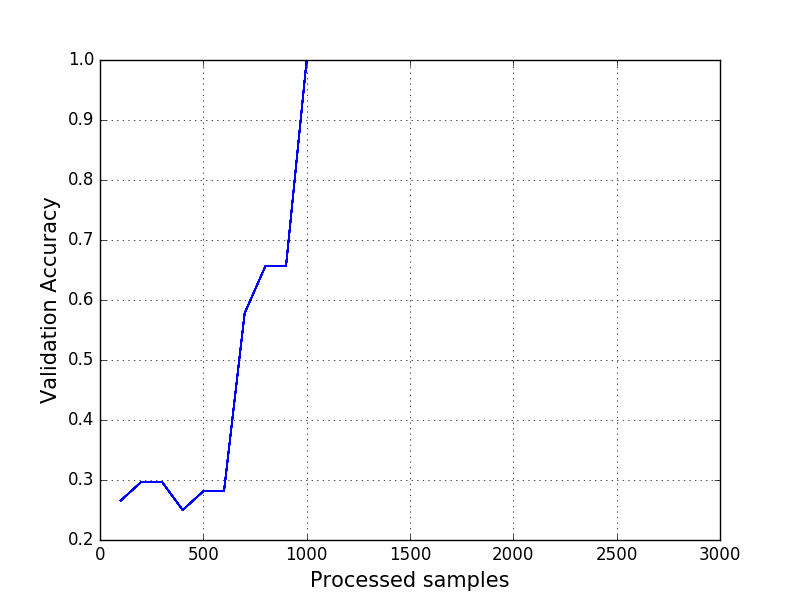

In [22]:
# TRAINING
# setting up running parameters
val_interval = 100
samples_to_process = 3000
samples_processed = 0
samples_val = []
costs, accs = [], []
plt.figure()
try:
    while samples_processed < samples_to_process:
        # load data
        X_tr, X_len_tr, t_in_tr, t_out_tr, t_len_tr, t_mask_tr,\
        text_inputs_tr, text_targets_in_tr, text_targets_out_tr = \
        inputs, inputs_seqlen, targets_in, targets_out, targets_seqlen, targets_mask,\
        text_inputs, text_targets_in, text_targets_out
        
        # make fetches
        fetches_tr = [train_op, loss, accuracy]
        # set up feed dict
        feed_dict_tr = {Xs: X_tr, X_len: X_len_tr, ts_in: t_in_tr,
             ts_out: t_out_tr, t_len: t_len_tr, t_mask: t_mask_tr}
        # run the model
        res = tuple(sess.run(fetches=fetches_tr, feed_dict=feed_dict_tr))
        _, batch_cost, batch_acc = res
        costs += [batch_cost]
        samples_processed += 1
        #if samples_processed % 1000 == 0: print batch_cost, batch_acc
        #validation data
        if samples_processed % val_interval == 0:
            #print "validating"
            fetches_val = [accuracy_valid, y_valid, alpha_valid]
            feed_dict_val = {Xs: X_val, X_len: X_len_val, ts_in: t_in_val,
             ts_out: t_out_val, t_len: t_len_val, t_mask: t_mask_val}
            res = tuple(sess.run(fetches=fetches_val, feed_dict=feed_dict_val))
            acc_val, output_val, alp_val = res
            samples_val += [samples_processed]
            accs += [acc_val]
            plt.plot(samples_val, accs, 'b-')
            plt.ylabel('Validation Accuracy', fontsize=15)
            plt.xlabel('Processed samples', fontsize=15)
            plt.title('', fontsize=20)
            plt.grid('on')
            plt.savefig("out_attention.png")
            display.display(display.Image(filename="out_attention.png"))
            display.clear_output(wait=True)
            
except KeyboardInterrupt:
    pass

<IPython.core.display.Javascript object>


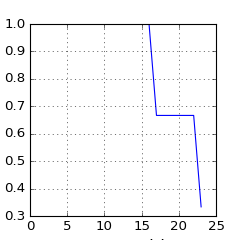

In [23]:
#plot of validation accuracy for each target position
plt.figure(figsize=(3,3))
plt.plot(np.mean(np.argmax(output_val,axis=2)==t_out_val,axis=0))
plt.ylabel('Accuracy', fontsize=15)
plt.xlabel('Target position', fontsize=15)
#plt.title('', fontsize=20)
plt.grid('on')
plt.show()

<IPython.core.display.Javascript object>


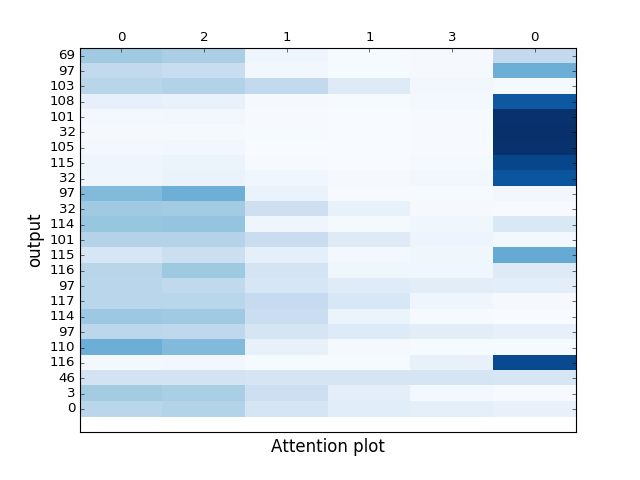

In [28]:
### attention plot
i = 1

column_labels = map(str, list(t_out_val[i]))
row_labels = map(str, (list(X_val[i])))
data = alp_val[i]
fig, ax = plt.subplots()
heatmap = ax.pcolor(data, cmap=plt.cm.Blues)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0])+0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(column_labels, minor=False)

plt.ylabel('output', fontsize=15)
plt.xlabel('Attention plot', fontsize=15)

plt.show()

<IPython.core.display.Javascript object>


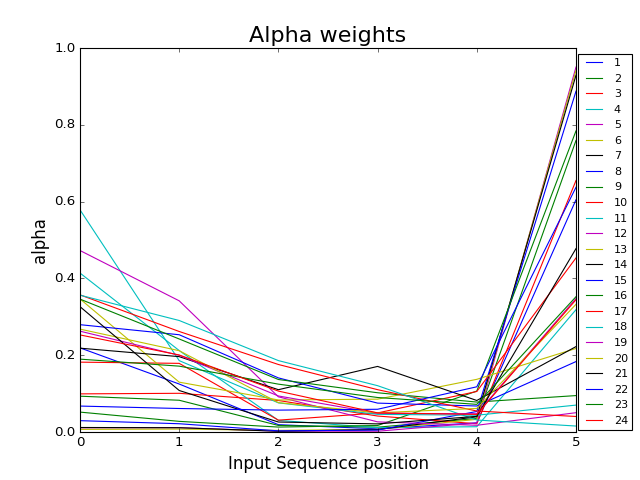

In [29]:
#Plot of average attention weight as a function of the sequence position for each of 
#the 24 targets in the output sequence i.e. each line is the mean postion of the 
#attention for each target position.

np.mean(alp_val, axis=0).shape
plt.figure()
plt.plot(np.mean(alp_val, axis=0).T)
plt.ylabel('alpha', fontsize=15)
plt.xlabel('Input Sequence position', fontsize=15)
plt.title('Alpha weights', fontsize=20)
plt.legend(map(str,range(1,25)), bbox_to_anchor=(1.125,1.0), fontsize=10)
plt.show()